In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import scipy as osp
from scipy.stats import kde

import paragami

import matplotlib.pyplot as plt
%matplotlib inline

from bnpmodeling_runjingdev import log_phi_lib, cluster_quantities_lib, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import \
        HyperparameterSensitivityLinearApproximation

from structure_vb_lib import structure_model_lib, posterior_quantities_lib
from structure_vb_lib.data_utils import cluster_admix_get_indx
from structure_vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import structure_vb_lib.structure_optimization_lib as s_optim_lib

import re
import copy

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
# data_file='../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz'
# out_filename='huang2011_fit'
# out_folder='../fits/hgdp_fits/'

data_file = '../data/huang2011_sub_nobs25_nloci75.npz'
out_filename = 'huang2011_fit_sub'
out_folder = '../fits/tmp/'

In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'
infl_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_infl_funcs.npz'

# Load data

In [5]:
print(data_file)

../data/huang2011_sub_nobs25_nloci75.npz


In [6]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [7]:
g_obs.shape

(25, 75, 3)

# Load initial fit

In [8]:
print(init_fit_file)

../fits/tmp/huang2011_fit_sub_alpha6.0.npz


In [9]:
vb_init_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, init_fit_meta_data = \
            structure_model_lib.load_structure_fit(init_fit_file)

In [10]:
vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)

# Define some posterior statistics

In [11]:
def get_e_num_ind_from_vb_free(vb_free, k): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    return posterior_quantities_lib.get_e_num_ind_per_cluster(vb_params_dict, 
                                                              gh_loc, gh_weights)[k]


In [12]:
def get_e_num_pred_clusters_from_vb_free(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.\
            get_e_num_pred_clusters(vb_params_dict,
                                    gh_loc,
                                    gh_weights, 
                                    n_samples = 1000,
                                    threshold = 0, 
                                    prng_key = jax.random.PRNGKey(3453), 
                                    return_samples = False)


# Plot influence functions

In [13]:
influence_data = np.load(infl_file)

### Plot influence function on cluster weights

In [14]:
logit_v_grid = influence_data['logit_v_grid']

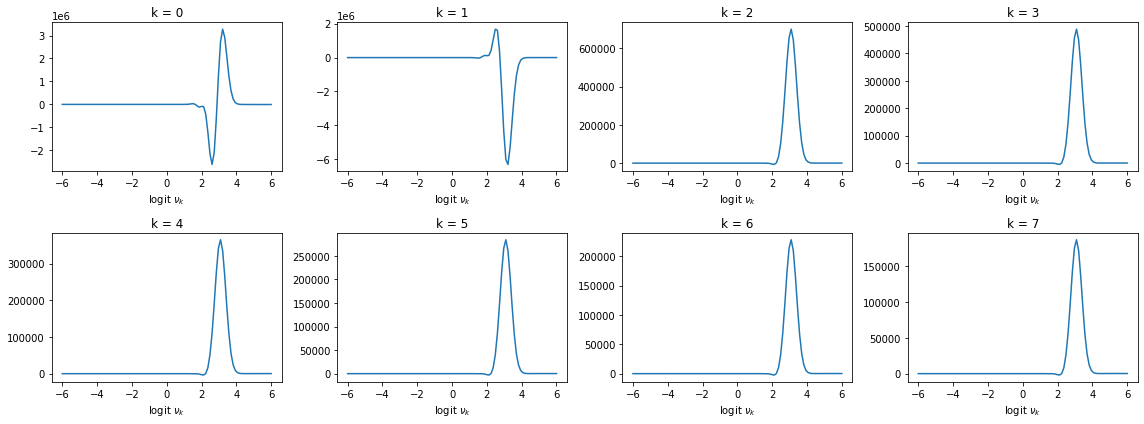

In [20]:
fig, ax = plt.subplots(2, 4, figsize = (16, 6)) 

for k in range(8): 
    
    k0 = k // 4
    k1 = k % 4
    ax[k0, k1].plot(logit_v_grid, 
                    influence_data['e_num_ind{}_inf_grid'.format(k)])
    
    ax[k0, k1].set_xlabel(r'logit $\nu_k$')
    ax[k0, k1].set_title('k = {}'.format(k))
    
fig.tight_layout()

### Plot influence function on expected number of clusters

These are expected number of predicted clusters, in particular

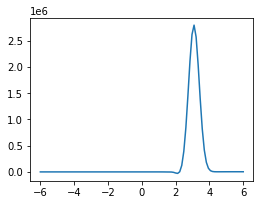

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (4, 3)) 

ax.plot(logit_v_grid, 
        influence_data['e_num_pred_clusters_inf_grid'])

# Function to plot a perturbation

In [17]:
def plot_perturbation(perturbation, delta): 
        
    # need the bare minimum to make plots
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami = vb_params_paragami, 
                                                 alpha0 = alpha0,
                                                 gh_loc = gh_loc, 
                                                 gh_weights = gh_weights,
                                                 logit_v_grid = None, 
                                                 influence_grid = None, 
                                                 delta = delta,
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    prior_perturbation.plot_perturbation();
    
    return prior_perturbation, f_obj

# Function to load vb parameters

In [18]:
def get_free_param_array(perturbation, delta):     
    
    #################
    # load linear response derivatives
    #################
    # print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.abs(lr_data['vb_opt'] - vb_init_free).max() < 1e-12
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    print('Derivative time: {:.3f}secs'.format(lr_data['lr_time_' + perturbation]))
    print('CG tolerance: ', lr_data['cg_tol'])
    
    ##################
    # load refit results
    ##################
    # get all files for that particular perturbation
    match_crit = out_filename + '_' + perturbation + '_delta{}_eps'.format(delta) + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_init_free]

    for i in range(len(refit_files)): 

        # print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
        assert meta_data['delta'] == delta
        
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))
    
    ###############
    # get linear response predictions 
    ###############
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_init_free + lr_data['dinput_dfun_' + perturbation] * epsilon * delta
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), epsilon_vec

# Function to make plots

In [19]:
def plot_post_stats(g, vb_list, epsilon_vec, ax, label = '', color = 'red'): 
    
    # plots the posterior quantity as a function of epsilon
    
    post_vec = onp.zeros(len(epsilon_vec))
    
    for i in range(len(epsilon_vec)): 
        post_vec[i] = g(vb_list[i])

    # plot
    ax.plot(epsilon_vec,
            post_vec, 
            'o-', 
            color = color,
            label = label)
    
    return post_vec

In [20]:
def plot_results_for_refit_and_lr(g, vb_refit_list, lr_list, epsilon_vec, ax): 
    
    post_vec_refit = plot_post_stats(g,
                                     vb_refit_list,
                                     epsilon_vec, 
                                     ax,
                                     label = 'refit', 
                                     color = '#1b9e77')
    
    post_vec_lr = plot_post_stats(g,
                                  lr_list,
                                  epsilon_vec,
                                  ax,
                                  label = 'lr', 
                                  color = '#d95f02')
    
    return post_vec_refit, post_vec_lr

# Plot results

In [21]:
def plot_infl_results(init_g, ghess, cross_hess, epsilon_vec, ax): 
    dg_dhyper = np.dot(ghess, cross_hess)
    lr2_vec = init_g + dg_dhyper * epsilon_vec

    ax.plot(epsilon_vec,
            lr2_vec,
            'o-', 
            color = '#7570b3',
            label = 'lr-infl')

In [22]:
def plot_results_for_perturbation(perturbation, delta): 
    prior_perturbation, f_obj = plot_perturbation(perturbation, delta)

    ##############
    # Load refit and LR results
    ##############
    vb_refit_list, lr_list, epsilon_vec = \
        get_free_param_array(perturbation, delta)
        
    ##############
    # compute cross-hessian for this perturbation
    ##############
    print('computing the cross-hessian for this perturbation ...')
    t0 = time.time() 
    dobj_dhyper = jax.jacobian(f_obj.hyper_par_objective_fun, 1)
    dobj_dhyper_dinput = jax.jacobian(dobj_dhyper, 0)
    cross_hess = dobj_dhyper_dinput(vb_init_free, 0.).squeeze()
    print('cross-hessian time: {:03f}sec'.format(time.time() - t0))
    
    ##############
    # plot expected number cluster weights
    ##############
    fig, ax = plt.subplots(2, 4, figsize = (16, 6), sharex = True) 

    for k in range(8): 

        k0 = k // 4
        k1 = k % 4

        # plot refit results and linear response results
        init_g = plot_results_for_refit_and_lr(lambda x : get_e_num_ind_from_vb_free(x, k = k), 
                                          vb_refit_list,
                                          lr_list,
                                          epsilon_vec = epsilon_vec, 
                                          ax = ax[k0, k1])[0][0]
        
        ax[k0, k1].set_title('cluster k = {}'.format(k))
        ax[k0, k1].set_ylabel('Exp. # individuals')
        
        # now plot results from influence function
        plot_infl_results(init_g, 
                          influence_data['e_num_ind{}_ghess'.format(k)],
                          cross_hess, 
                          epsilon_vec,
                          ax[k0, k1])
        
        if k0 == 1: 
            ax[k0, k1].set_xlabel('epsilon')
    
    
    ax[0, 0].legend()
    fig.tight_layout()
    
    ##############
    # plot expected number of clusters
    ##############
    fig, ax = plt.subplots(1, 1, figsize = (4, 3)) 
    
    init_g = plot_results_for_refit_and_lr(get_e_num_pred_clusters_from_vb_free,
                                          vb_refit_list,
                                          lr_list,
                                          epsilon_vec = epsilon_vec, 
                                          ax = ax)[0][0]
    
    
    # now plot results from influence function    
    plot_infl_results(init_g, 
                      influence_data['e_num_pred_clusters_ghess'],
                      cross_hess, 
                      epsilon_vec,
                      ax)


    
    ax.set_title('Number of clusters')
    ax.set_xlabel('Epsilon')
    ax.set_ylabel('Exp. # pred. clusters')
    ax.legend()

# Sigmoidal perturbations

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.388126e-08
  warnings.warn(


Derivative time: 0.175secs
CG tolerance:  0.01
Optim time at epsilon = 1: 9.226secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 1.344086sec


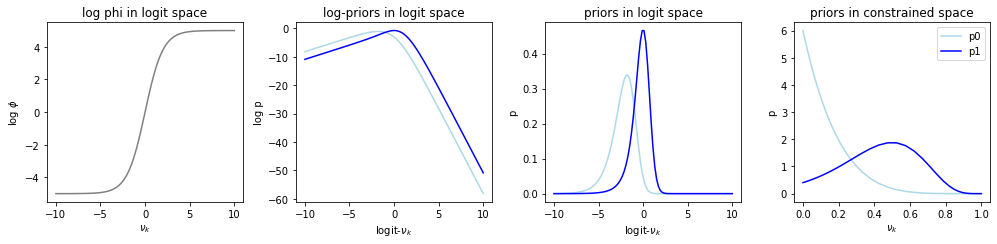

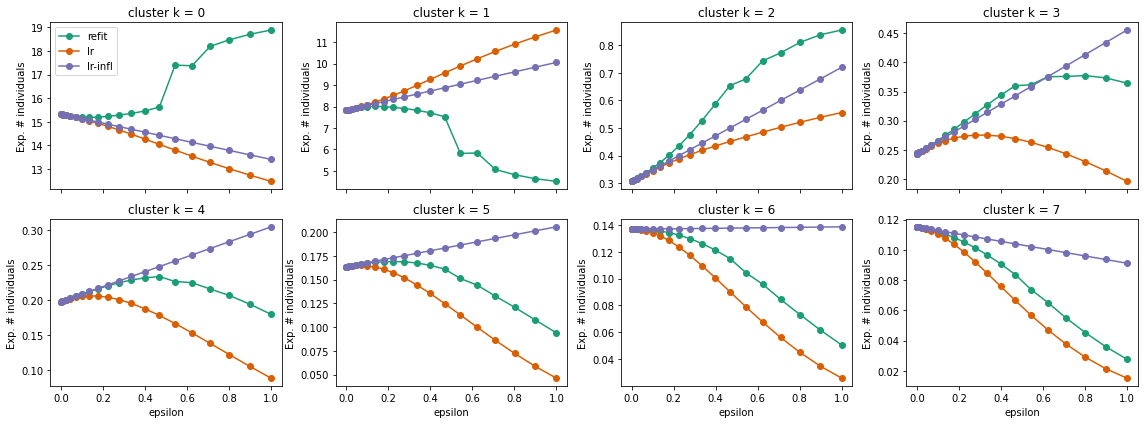

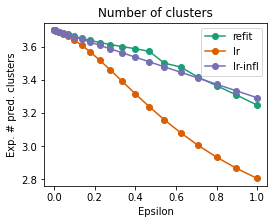

In [23]:
perturbation = 'sigmoidal'
plot_results_for_perturbation(perturbation, delta = 5)

Derivative time: 0.175secs
CG tolerance:  0.01
Optim time at epsilon = 1: 7.112secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.050376sec


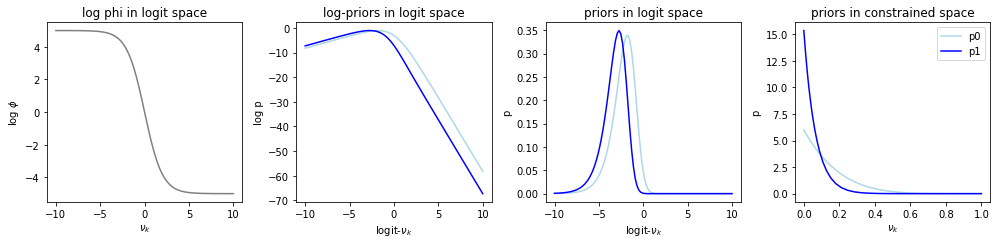

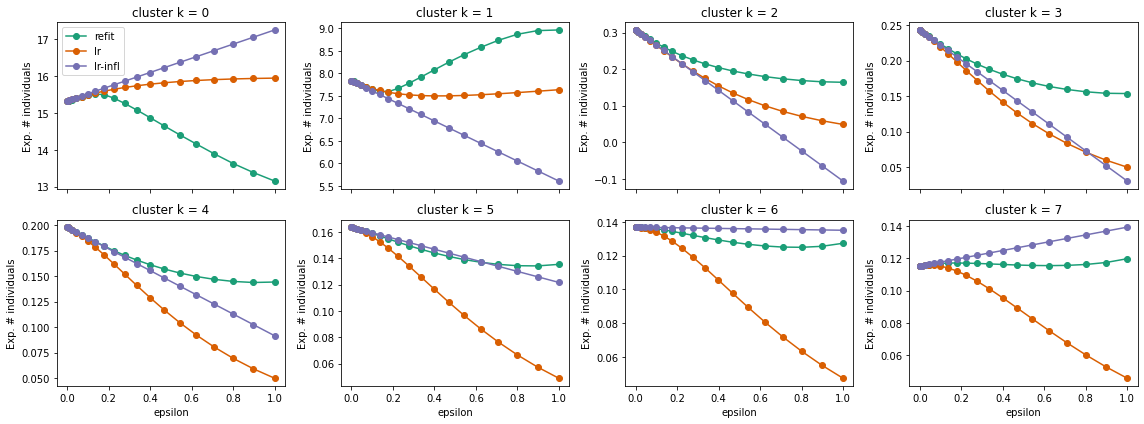

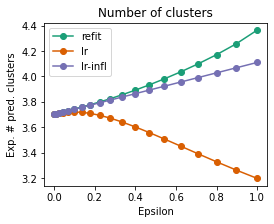

In [24]:
perturbation = 'sigmoidal'
plot_results_for_perturbation(perturbation, delta = -5)

# Perturbations corresponding to changing alpha

Derivative time: 0.118secs
CG tolerance:  0.01
Optim time at epsilon = 1: 13.819secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.497406sec


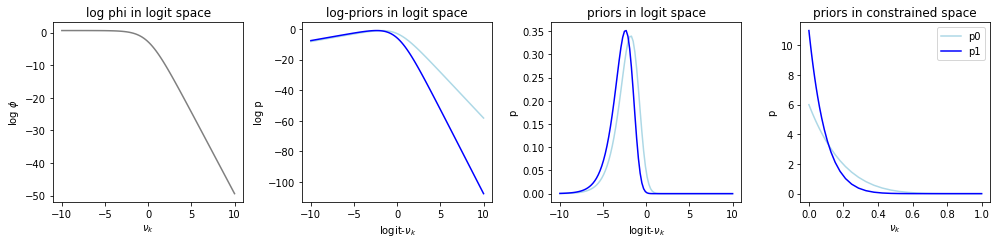

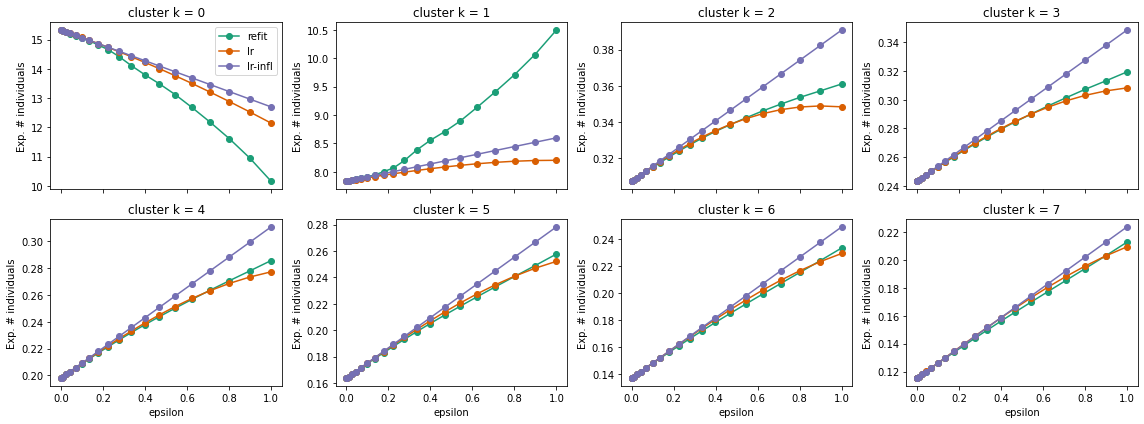

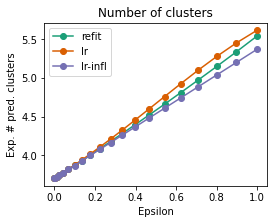

In [25]:
perturbation = 'alpha_pert_pos'
plot_results_for_perturbation(perturbation, delta = 1)

Derivative time: 0.117secs
CG tolerance:  0.01
Optim time at epsilon = 1: 8.165secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.071353sec


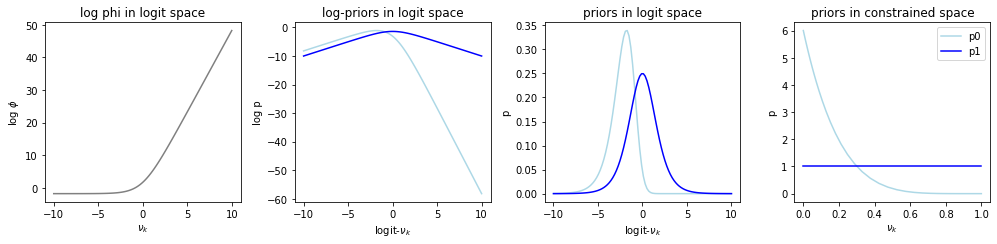

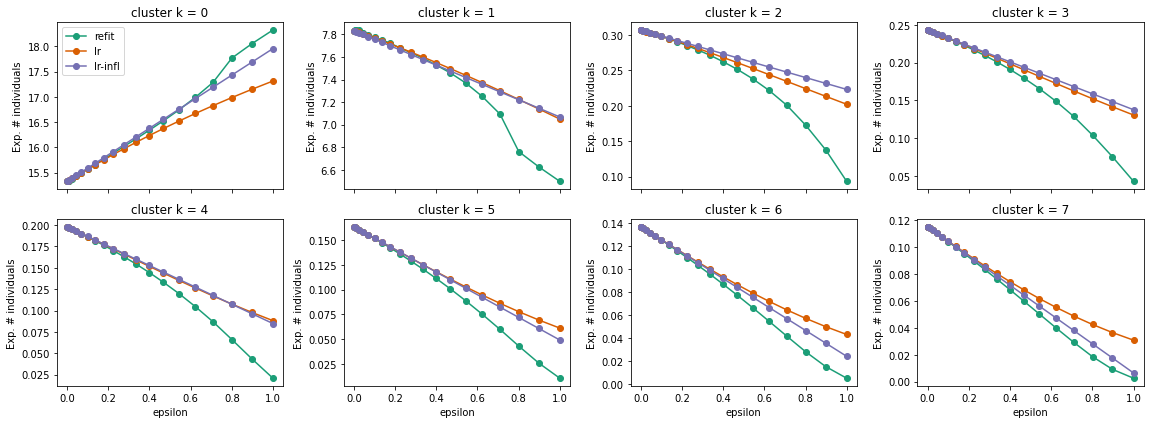

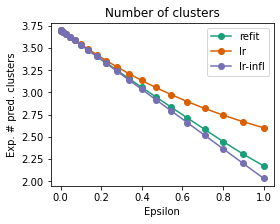

In [26]:
perturbation = 'alpha_pert_neg'
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.091946e-08
  warnings.warn(


Derivative time: 0.112secs
CG tolerance:  0.01
Optim time at epsilon = 1: 13.381secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.072391sec


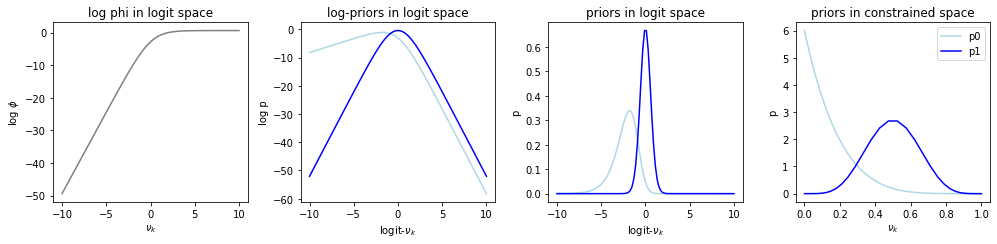

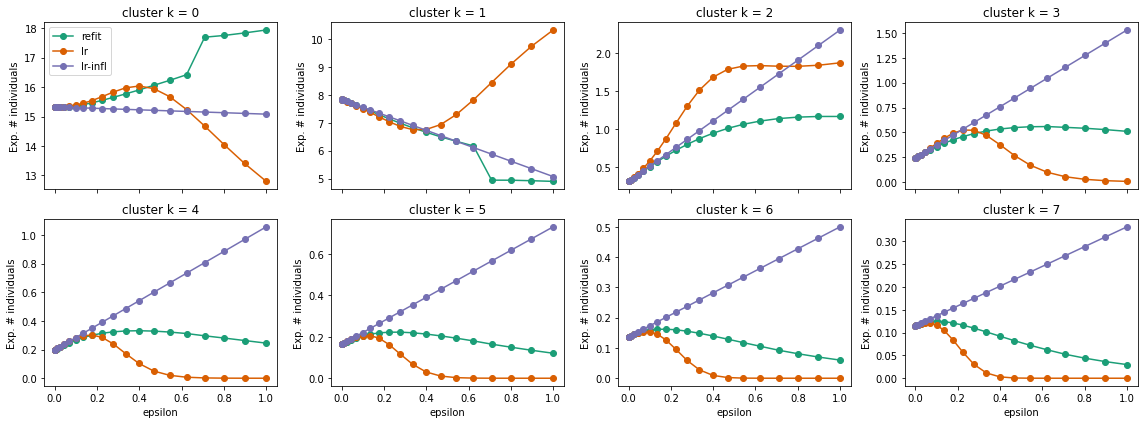

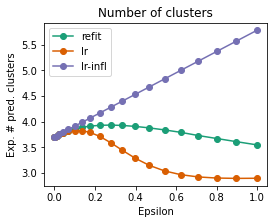

In [27]:
perturbation = 'alpha_pert_pos_xflip'
plot_results_for_perturbation(perturbation, delta = 1)

In [28]:
# perturbation = 'alpha_pert_neg_xflip'
# plot_perturbation(perturbation)
# plot_results_for_perturbation(perturbation)

# Gaussian bumps

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.227507e-06
  warnings.warn(


Derivative time: 0.168secs
CG tolerance:  0.01
Optim time at epsilon = 1: 9.656secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.106495sec


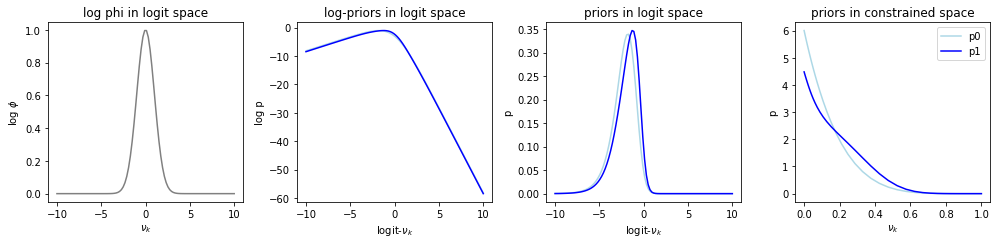

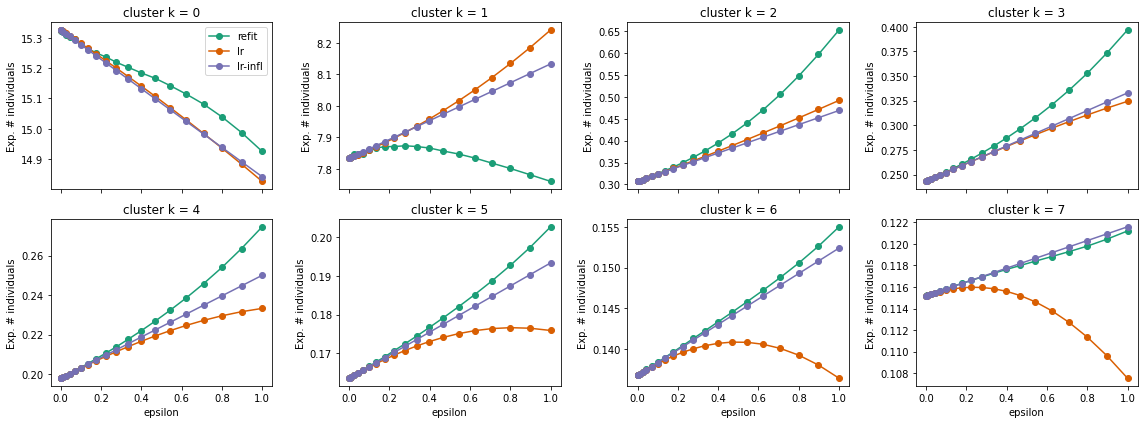

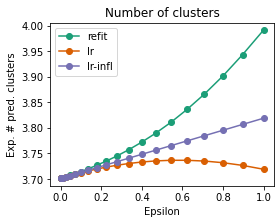

In [29]:
perturbation = 'gauss_pert1'
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.001209e-08
  warnings.warn(


Derivative time: 0.168secs
CG tolerance:  0.01
Optim time at epsilon = 1: 8.970secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.055959sec


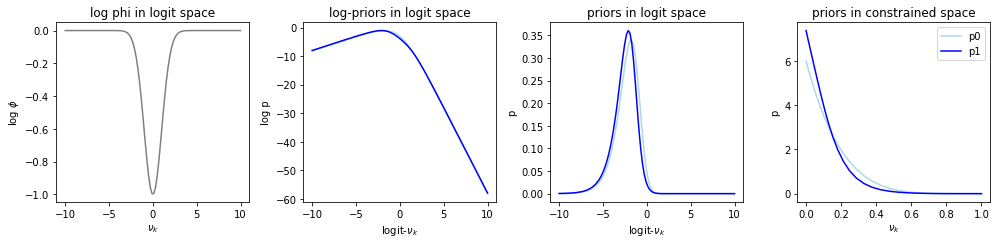

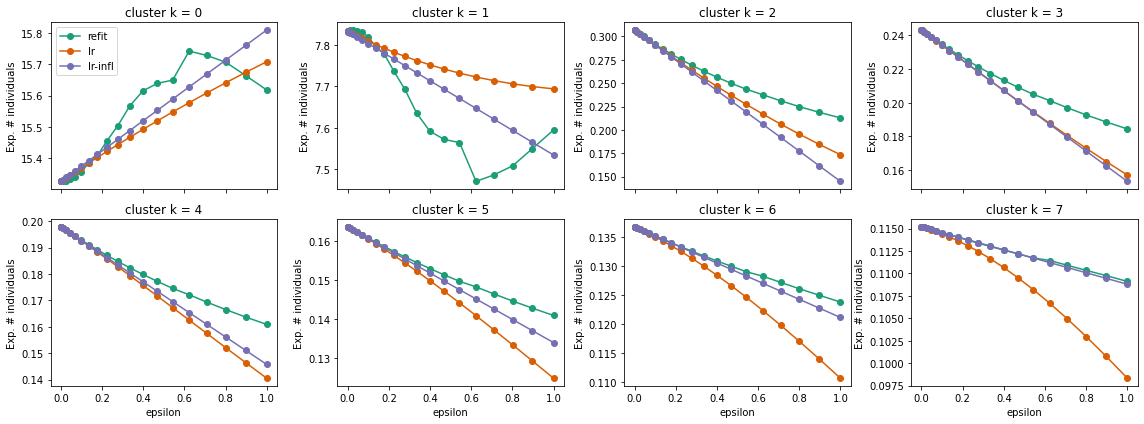

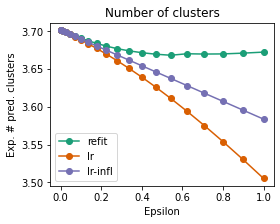

In [30]:
perturbation = 'gauss_pert1'
plot_results_for_perturbation(perturbation, delta = -1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.412626e-07
  warnings.warn(


Derivative time: 0.161secs
CG tolerance:  0.01
Optim time at epsilon = 1: 5.427secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.053440sec


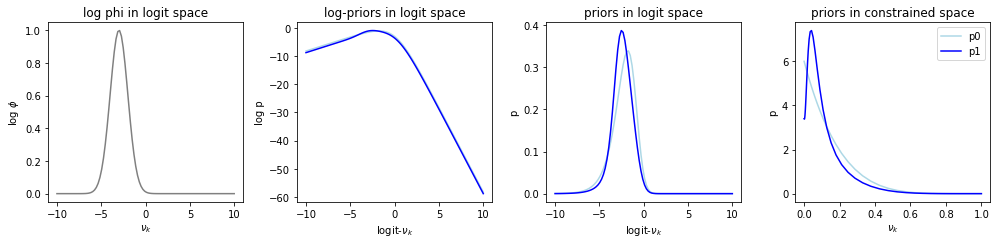

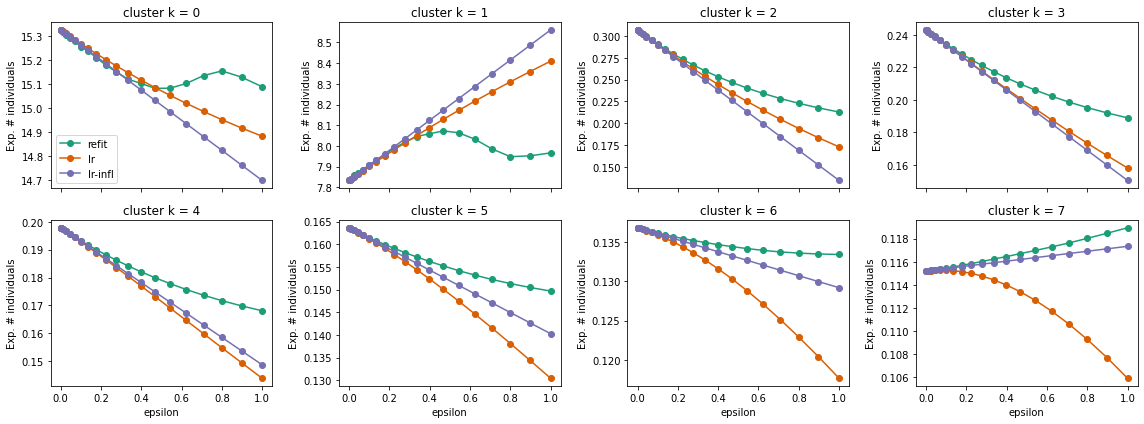

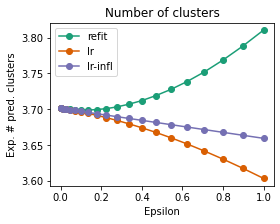

In [31]:
perturbation = 'gauss_pert2'
plot_results_for_perturbation(perturbation, delta = 1)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.524900e-08
  warnings.warn(


Derivative time: 0.161secs
CG tolerance:  0.01
Optim time at epsilon = 1: 6.833secs
computing the cross-hessian for this perturbation ...
cross-hessian time: 0.053905sec


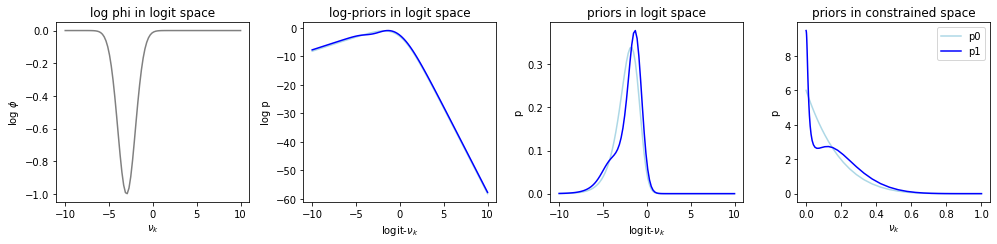

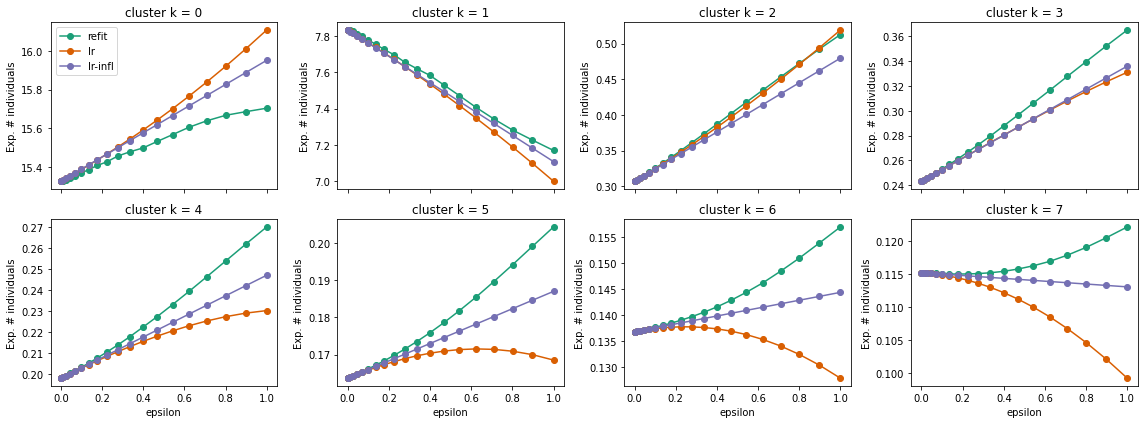

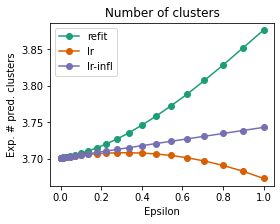

In [32]:
perturbation = 'gauss_pert2'
plot_results_for_perturbation(perturbation, delta = -1)